<a href="https://colab.research.google.com/github/shivi13102/Supernova-Dectection/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
pip install scipy astropy astroalign photutils opencv-python scikit-image tensorflow tqdm

In [31]:
!pip install --upgrade scikit-image

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from astropy.io import fits
import astroalign as aa
import shutil
import random
from tqdm import tqdm

import os
import json
from zipfile import ZipFile
from zipfile import ZipExtFile
from PIL import Image

In [4]:
!pip install kaggle

In [5]:
kaggle_credentials = json.load(open("kaggle (2).json"))

In [6]:
#setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

In [7]:
!kaggle datasets download jeseenthaksajan/task-4-dataset

Dataset URL: https://www.kaggle.com/datasets/jeseenthaksajan/task-4-dataset
License(s): CC0-1.0
100% 1.88G/1.89G [00:21<00:00, 38.7MB/s]
100% 1.89G/1.89G [00:21<00:00, 94.1MB/s]


In [8]:
#Unzip the downloaded dataset
with ZipFile("task-4-dataset.zip", 'r') as zip_ref:
  zip_ref.extractall()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **Preprocessing the images**

In [16]:
# Define paths
input_folder = '/content/Panstarrs/images'  # Folder containing the original images
output_folder = 'preprocessed_images'  # Folder to save preprocessed images

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Define preprocessing parameters
image_size = (128, 128)  # Resize all images to 128x128 pixels

def preprocess_image(image_path, output_path):
    """
    Preprocess a single image: resize, normalize, and save.
    """
    try:
        # Read the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        if image is None:
            print(f"Warning: Could not read {image_path}. Skipping.")
            return False

        # Resize the image
        image_resized = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)

        # Normalize pixel values (0 to 1)
        image_normalized = image_resized / 255.0

        # Save the preprocessed image
        np.save(output_path, image_normalized)  # Save as .npy file for efficiency
        return True
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return False

# Loop through all images in the input folder
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))]

print(f"Found {len(image_files)} images. Starting preprocessing...")

for image_file in tqdm(image_files, desc="Preprocessing images"):
    input_path = os.path.join(input_folder, image_file)
    output_path = os.path.join(output_folder, os.path.splitext(image_file)[0] + '.npy')
    preprocess_image(input_path, output_path)

print("Preprocessing complete. Preprocessed images saved in 'preprocessed_images' folder.")

Found 13163 images. Starting preprocessing...


Preprocessing images: 100%|██████████| 13163/13163 [01:21<00:00, 161.29it/s]

Preprocessing complete. Preprocessed images saved in 'preprocessed_images' folder.


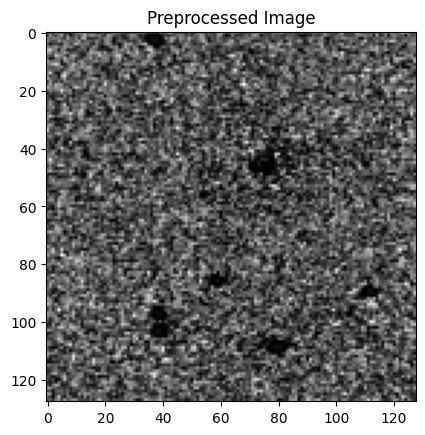

In [26]:
sample_image = np.load('/content/preprocessed_images/0029.npy')
plt.imshow(sample_image, cmap='gray')
plt.title('Preprocessed Image')
plt.show()

# **Image Differencing**

In [23]:
# Define paths
preprocessed_folder = '/content/preprocessed_images'  # Folder containing preprocessed .npy images
reference_image_path = '/content/preprocessed_images/0042.npy'  # Path to the reference image
difference_folder = 'image_differences'  # Folder to save the difference images

# Create output folder if it doesn't exist
os.makedirs(difference_folder, exist_ok=True)

# Load the reference image
try:
    reference_image = np.load(reference_image_path)
    print("Reference image loaded successfully.")
except Exception as e:
    raise FileNotFoundError(f"Could not load reference image: {e}")

# Ensure the reference image is of the same size as preprocessed images
image_size = reference_image.shape

# Function for image differencing
def image_difference(image_path, output_path, reference_image):
    """
    Perform image differencing and save the result, with handling for division by zero.
    """
    try:
        # Load the new image
        image = np.load(image_path)

        # Ensure the new image matches the reference image dimensions
        if image.shape != reference_image.shape:
            print(f"Warning: Image shape mismatch for {image_path}. Skipping.")
            return False

        # Compute the absolute difference
        diff_image = np.abs(image - reference_image)

        # Check for zero differences (to avoid division by zero)
        if np.max(diff_image) == 0:
            print(f"Warning: No difference found for {image_path}. Skipping.")
            diff_image = np.zeros_like(diff_image)  # Set to a black image for no difference
        else:
            # Normalize the difference for visualization
            diff_image = (diff_image / np.max(diff_image)) * 255.0

        # Convert to uint8 (8-bit image)
        diff_image = diff_image.astype(np.uint8)

        # Save the difference image
        cv2.imwrite(output_path, diff_image)
        return True
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return False

# Perform image differencing on all preprocessed images
image_files = [f for f in os.listdir(preprocessed_folder) if f.endswith('.npy')]

print(f"Found {len(image_files)} preprocessed images. Starting image differencing...")

for image_file in tqdm(image_files, desc="Image Differencing"):
    input_path = os.path.join(preprocessed_folder, image_file)
    output_path = os.path.join(difference_folder, os.path.splitext(image_file)[0] + '.png')
    image_difference(input_path, output_path, reference_image)

print("\nImage differencing complete. Difference images saved in 'image_differences' folder.")

Reference image loaded successfully.
Found 13163 preprocessed images. Starting image differencing...


Image Differencing:  78%|███████▊  | 10265/13163 [00:09<00:02, 1100.38it/s]

Image Differencing: 100%|██████████| 13163/13163 [00:12<00:00, 1060.94it/s]


Image differencing complete. Difference images saved in 'image_differences' folder.


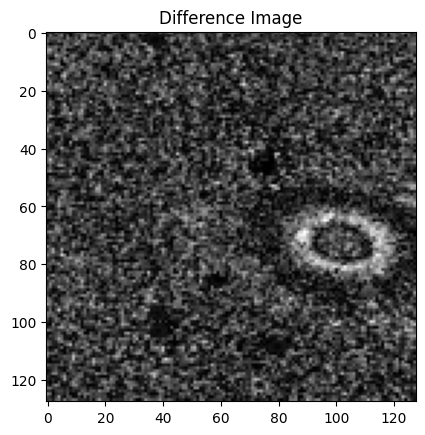

In [27]:
sample_diff_path = '/content/image_differences/0029.png'
sample_diff = cv2.imread(sample_diff_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(sample_diff, cmap='gray')
plt.title('Difference Image')
plt.show()

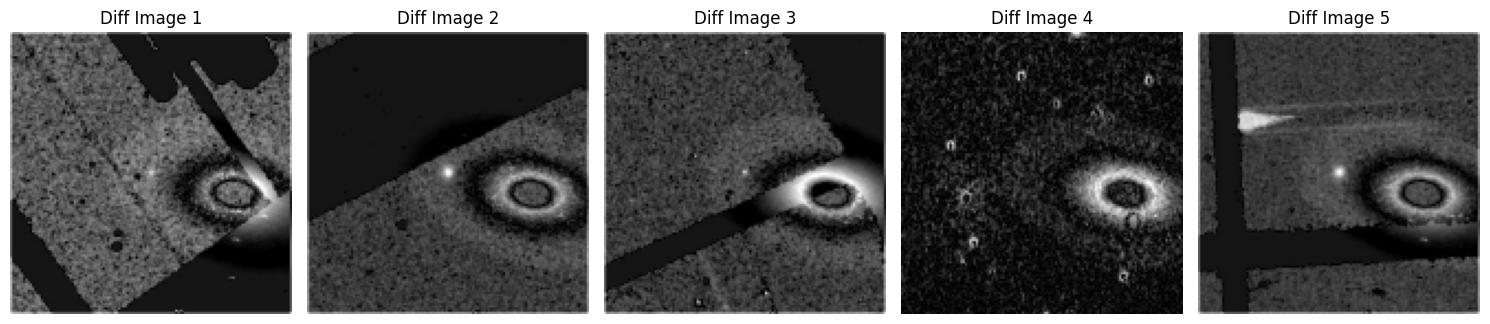

In [28]:
# Define paths
difference_folder = 'image_differences'  # Folder containing the difference images

# List all difference images
difference_images = [f for f in os.listdir(difference_folder) if f.endswith('.png')]

# Display a few sample difference images to manually inspect
def display_sample_difference_images(images, num_images=5):
    """
    Display a few sample difference images for manual inspection.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, image_file in enumerate(images[:num_images]):
        image_path = os.path.join(difference_folder, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Plot the image
        ax = axes[i]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Diff Image {i+1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display sample difference images
display_sample_difference_images(difference_images, num_images=5)

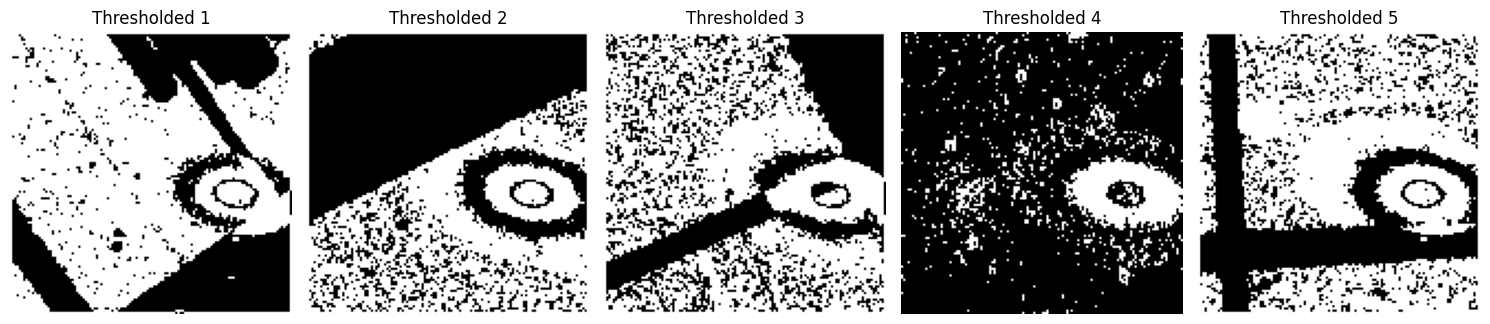

In [29]:
def apply_threshold(image, threshold_value=50):
    """
    Apply a threshold to the difference image to highlight significant differences.
    """
    _, thresholded_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    return thresholded_image

# Display thresholded images for clearer visualization
def display_thresholded_images(images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, image_file in enumerate(images[:num_images]):
        image_path = os.path.join(difference_folder, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Apply threshold
        thresholded_image = apply_threshold(image)

        # Plot the thresholded image
        ax = axes[i]
        ax.imshow(thresholded_image, cmap='gray')
        ax.set_title(f"Thresholded {i+1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display thresholded images
display_thresholded_images(difference_images, num_images=5)
